# Random forest classifier to predict word count for different sections

### Filtering Datasets

Imports

In [1]:
import re
import os
import json
import pandas as pd
import numpy as np
mimic_folder = '/mnt/datadisk/mimic/mimic-iv-2.2/hosp'

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd

# Set option to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)  # Adjust as necessary


In [4]:
df_discharge_train_segmented = pd.read_csv('/mnt/datadisk/mimic/discharge/dataset/df_discharge_train_segmented.csv')
df_discharge_test_phase_1_segmented = pd.read_csv('/mnt/datadisk/mimic/discharge/dataset/df_discharge_test_phase_1_segmented.csv')
df_discharge_test_phase_2_segmented = pd.read_csv('/mnt/datadisk/mimic/discharge/dataset/df_discharge_test_phase_2_segmented.csv')


In [9]:
df_discharge_train_segmented.fillna('', inplace=True)
df_discharge_test_phase_1_segmented.fillna('', inplace=True)
df_discharge_test_phase_2_segmented.fillna('', inplace=True)

/tmp/ipykernel_118321/1625848521.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_discharge_train_segmented.fillna('', inplace=True)
/tmp/ipykernel_118321/1625848521.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_discharge_test_phase_1_segmented.fillna('', inplace=True)
/tmp/ipykernel_118321/1625848521.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_discharge_test_phase_2_segmented.fillna('', inplace=True)


In [10]:
df_discharge_train_segmented = df_discharge_train_segmented[['subject_id','note_id', 'hadm_id', 'note_type', 'note_seq', 'charttime',
       'storetime', 'additional_info', 'segmented_content_length',
       'patients_admissions', 'transfer_summary', 'diagnoses', 'Service',
       'Allergies', 'Attending', 'Chief Complaint',
       'Major Surgical or Invasive Procedure', 'History of Present Illness',
       'REVIEW OF SYSTEMS:', 'Past Medical History', 'Social History',
       'Family History', 'Physical Exam', 'Pertinent Results',
       'Imaging and Studies','brief_hospital_course', 'discharge_instructions', 'admission medications', 'Discharge Medications',
       'Discharge Disposition', 'Discharge Diagnosis', 'Discharge Condition',
       'Followup Instructions', 'Provider', 'code status'
       ]]


df_discharge_test_phase_1_segmented  = df_discharge_test_phase_1_segmented[['subject_id','note_id', 'hadm_id', 'note_type', 'note_seq', 'charttime',
       'storetime', 'additional_info', 'segmented_content_length',
       'patients_admissions', 'transfer_summary', 'diagnoses', 'Service',
       'Allergies', 'Attending', 'Chief Complaint',
       'Major Surgical or Invasive Procedure', 'History of Present Illness',
       'REVIEW OF SYSTEMS:', 'Past Medical History', 'Social History',
       'Family History', 'Physical Exam', 'Pertinent Results',
       'Imaging and Studies','brief_hospital_course', 'discharge_instructions', 'admission medications', 'Discharge Medications',
       'Discharge Disposition', 'Discharge Diagnosis', 'Discharge Condition',
       'Followup Instructions', 'Provider', 'code status'
       ]]

df_discharge_test_phase_2_segmented = df_discharge_test_phase_2_segmented[['subject_id','note_id', 'hadm_id', 'note_type', 'note_seq', 'charttime',
       'storetime', 'additional_info', 'segmented_content_length',
       'patients_admissions', 'transfer_summary', 'diagnoses', 'Service',
       'Allergies', 'Attending', 'Chief Complaint',
       'Major Surgical or Invasive Procedure', 'History of Present Illness',
       'REVIEW OF SYSTEMS:', 'Past Medical History', 'Social History',
       'Family History', 'Physical Exam', 'Pertinent Results',
       'Imaging and Studies','brief_hospital_course', 'discharge_instructions', 'admission medications', 'Discharge Medications',
       'Discharge Disposition', 'Discharge Diagnosis', 'Discharge Condition',
       'Followup Instructions', 'Provider', 'code status'
       ]]

In [11]:
df_discharge_train_segmented.columns

Index(['subject_id', 'note_id', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'additional_info', 'segmented_content_length',
       'patients_admissions', 'transfer_summary', 'diagnoses', 'Service',
       'Allergies', 'Attending', 'Chief Complaint',
       'Major Surgical or Invasive Procedure', 'History of Present Illness',
       'REVIEW OF SYSTEMS:', 'Past Medical History', 'Social History',
       'Family History', 'Physical Exam', 'Pertinent Results',
       'Imaging and Studies', 'brief_hospital_course',
       'discharge_instructions', 'admission medications',
       'Discharge Medications', 'Discharge Disposition', 'Discharge Diagnosis',
       'Discharge Condition', 'Followup Instructions', 'Provider',
       'code status'],
      dtype='object')

In [12]:

column_names = df_discharge_train_segmented.columns[15:-2]
# calculate word count of those columns
for column_name in column_names:
    df_discharge_train_segmented[column_name+'_word_count'] = df_discharge_train_segmented[column_name].apply(lambda x: len(x.split()))
    
# calculate the statistics of those columns, save in a df, with row as column name, and columns as statistics
df_discharge_train_segmented_statistics = pd.DataFrame(columns=['mean', 'std', 'min', '25%', '50%', '75%', 'max'])
for column_name in column_names:
    df_discharge_train_segmented_statistics.loc[column_name] = df_discharge_train_segmented[column_name].describe()[1:]
    

In [13]:
for column_name in column_names:
    df_discharge_test_phase_1_segmented[column_name+'_word_count'] = df_discharge_test_phase_1_segmented[column_name].apply(lambda x: len(x.split()))
    df_discharge_test_phase_2_segmented[column_name+'_word_count'] = df_discharge_test_phase_2_segmented[column_name].apply(lambda x: len(x.split()))
   

In [14]:
# 1.
df_transfers_count = pd.read_csv('/mnt/datadisk/mimic/discharge/other_tables/transfers_count.csv')
# 2. 
df_diagnosis_count = pd.read_csv('/mnt/datadisk/mimic/discharge/other_tables/diagnosis_count.csv')
# 3.
df_prescription_counts = pd.read_csv('/mnt/datadisk/mimic/discharge/other_tables/prescription_count.csv')
# 4.
df_procedure_counts = pd.read_csv('/mnt/datadisk/mimic/discharge/other_tables/procedure_counts.csv')
# 5. 
df_medication_counts = pd.read_csv('/mnt/datadisk/mimic/discharge/other_tables/emar.csv')
# 6. 
df_order_counts = pd.read_csv('/mnt/datadisk/mimic/discharge/other_tables/order_counts_pivot.csv')
# 7.
df_icu = pd.read_csv('/mnt/datadisk/mimic/discharge/other_tables/icu.csv')
# 8.
df_patients = pd.read_csv('/mnt/datadisk/mimic/discharge/other_tables/patients.csv')
# 9.
df_admissions = pd.read_csv('/mnt/datadisk/mimic/discharge/other_tables/admissions.csv')
# 10.
with open('transfer_total_duration_dict.json', 'r') as f:
    df_total_duration = json.load(f)

df_total_duration = pd.DataFrame(df_total_duration.items(), columns=['hadm_id', 'transfer_total_duration'])
df_total_duration["hadm_id"] = df_total_duration["hadm_id"].astype(int)

In [15]:
base_df = df_transfers_count

# Sequentially merge each DataFrame on 'hadm_id'
merged_df = base_df.merge(df_diagnosis_count, on='hadm_id', how='left')
merged_df = merged_df.merge(df_prescription_counts, on='hadm_id', how='left')
merged_df = merged_df.merge(df_procedure_counts, on='hadm_id', how='left')
merged_df = merged_df.merge(df_medication_counts, on='hadm_id', how='left')
merged_df = merged_df.merge(df_order_counts, on='hadm_id', how='left')
merged_df = merged_df.merge(df_icu, on='hadm_id', how='left')
merged_df = merged_df.merge(df_patients, on='hadm_id', how='left')
merged_df = merged_df.merge(df_admissions, on='hadm_id', how='left')
merged_df = merged_df.merge(df_total_duration, on='hadm_id', how='left')
# Optionally, fill NaN values with zeros if these represent counts (check this assumption!)
merged_df = merged_df.fillna(0)
merged_df['hadm_id'] = merged_df['hadm_id'].astype('int', errors='ignore')
#
# Display the head of the merged DataFrame to check the initial rows
print(merged_df.head())

    hadm_id  transfers_count  diagnosis_count  prescription_count  \
0  20000019                3             12.0                29.0   
1  20000024                3             10.0                17.0   
2  20000034                2             28.0                37.0   
3  20000041                3             10.0                34.0   
4  20000057                3             23.0                20.0   

   procedure_count  medication_count  ADT orders  Blood Bank  Cardiology  \
0              0.0               0.0         5.0         0.0         0.0   
1              0.0               9.0         9.0         3.0         0.0   
2              0.0              65.0         3.0         0.0         0.0   
3              1.0               0.0         3.0         0.0         0.0   
4              0.0               0.0         4.0         1.0         1.0   

   Consults  Critical Care  General Care  Hemodialysis  IV therapy   Lab  \
0       1.0            0.0           8.0           0

In [16]:
merged_df = merged_df.drop_duplicates(subset='hadm_id', keep='first')


In [17]:

# merge transfer_total_duration_dict and each of the df_discharge_train_segmented, df_discharge_valid_segmented, df_discharge_test_phase_1_segmented, df_discharge_test_phase_2_segmented
df_all = df_discharge_train_segmented.merge(merged_df, on='hadm_id',how='left')


In [18]:
df_discharge_test_phase_1_segmented = df_discharge_test_phase_1_segmented.merge(merged_df, on='hadm_id',how='left')
df_discharge_test_phase_2_segmented = df_discharge_test_phase_2_segmented.merge(merged_df, on='hadm_id',how='left')

In [19]:
df_all[['Chief Complaint_word_count',
       'Major Surgical or Invasive Procedure_word_count',
       'History of Present Illness_word_count',
       'REVIEW OF SYSTEMS:_word_count', 'Past Medical History_word_count',
       'Social History_word_count', 'Family History_word_count',
       'Physical Exam_word_count', 'Pertinent Results_word_count',
       'Imaging and Studies_word_count',
       'brief_hospital_course_word_count',
       'admission medications_word_count',
       'Discharge Medications_word_count',
       'Discharge Disposition_word_count',
       'Discharge Diagnosis_word_count', 'Discharge Condition_word_count',
       'discharge_instructions_word_count',
       'Followup Instructions_word_count', 'transfers_count',
       'diagnosis_count', 'prescription_count', 'procedure_count',
       'medication_count', 'ADT orders', 'Blood Bank', 'Cardiology',
       'Consults', 'Critical Care', 'General Care', 'Hemodialysis',
       'IV therapy', 'Lab', 'Medications', 'Neurology', 'Nutrition', 'OB',
       'Radiology', 'Respiratory', 'TPN']] = df_all[['Chief Complaint_word_count',
       'Major Surgical or Invasive Procedure_word_count',
       'History of Present Illness_word_count',
       'REVIEW OF SYSTEMS:_word_count', 'Past Medical History_word_count',
       'Social History_word_count', 'Family History_word_count',
       'Physical Exam_word_count', 'Pertinent Results_word_count',
       'Imaging and Studies_word_count',
       'brief_hospital_course_word_count',
       'admission medications_word_count',
       'Discharge Medications_word_count',
       'Discharge Disposition_word_count',
       'Discharge Diagnosis_word_count', 'Discharge Condition_word_count',
       'discharge_instructions_word_count',
       'Followup Instructions_word_count', 'transfers_count',
       'diagnosis_count', 'prescription_count', 'procedure_count',
       'medication_count', 'ADT orders', 'Blood Bank', 'Cardiology',
       'Consults', 'Critical Care', 'General Care', 'Hemodialysis',
       'IV therapy', 'Lab', 'Medications', 'Neurology', 'Nutrition', 'OB',
       'Radiology', 'Respiratory', 'TPN']].astype('int', errors='ignore')

df_all['gender'] = df_all['gender'].astype('category')
gender_dummies = pd.get_dummies(df_all['gender'], prefix='gender')
df_all = pd.concat([df_all, gender_dummies], axis=1)

# Optionally, drop the original 'gender' column if you no longer need it
df_all.drop('gender', axis=1, inplace=True)

# Convert 'hospital_expire_flag' from int64 to bool
df_all['hospital_expire_flag'] = df_all['hospital_expire_flag'].astype(bool)


In [20]:

df_discharge_test_phase_1_segmented[['Chief Complaint_word_count',
       'Major Surgical or Invasive Procedure_word_count',
       'History of Present Illness_word_count',
       'REVIEW OF SYSTEMS:_word_count', 'Past Medical History_word_count',
       'Social History_word_count', 'Family History_word_count',
       'Physical Exam_word_count', 'Pertinent Results_word_count',
       'Imaging and Studies_word_count',
       'brief_hospital_course_word_count',
       'admission medications_word_count',
       'Discharge Medications_word_count',
       'Discharge Disposition_word_count',
       'Discharge Diagnosis_word_count', 'Discharge Condition_word_count',
       'discharge_instructions_word_count',
       'Followup Instructions_word_count', 'transfers_count',
       'diagnosis_count', 'prescription_count', 'procedure_count',
       'medication_count', 'ADT orders', 'Blood Bank', 'Cardiology',
       'Consults', 'Critical Care', 'General Care', 'Hemodialysis',
       'IV therapy', 'Lab', 'Medications', 'Neurology', 'Nutrition', 'OB',
       'Radiology', 'Respiratory', 'TPN']].astype('int', errors='ignore')

df_discharge_test_phase_1_segmented['gender'] = df_discharge_test_phase_1_segmented['gender'].astype('category')
gender_dummies = pd.get_dummies(df_discharge_test_phase_1_segmented['gender'], prefix='gender')
df_discharge_test_phase_1_segmented = pd.concat([df_discharge_test_phase_1_segmented, gender_dummies], axis=1)

# Optionally, drop the original 'gender' column if you no longer need it
df_discharge_test_phase_1_segmented.drop('gender', axis=1, inplace=True)

# Convert 'hospital_expire_flag' from int64 to bool
df_discharge_test_phase_1_segmented['hospital_expire_flag'] = df_discharge_test_phase_1_segmented['hospital_expire_flag'].astype(bool)


In [21]:


df_discharge_test_phase_2_segmented[['Chief Complaint_word_count',
       'Major Surgical or Invasive Procedure_word_count',
       'History of Present Illness_word_count',
       'REVIEW OF SYSTEMS:_word_count', 'Past Medical History_word_count',
       'Social History_word_count', 'Family History_word_count',
       'Physical Exam_word_count', 'Pertinent Results_word_count',
       'Imaging and Studies_word_count',
       'brief_hospital_course_word_count',
       'admission medications_word_count',
       'Discharge Medications_word_count',
       'Discharge Disposition_word_count',
       'Discharge Diagnosis_word_count', 'Discharge Condition_word_count',
       'discharge_instructions_word_count',
       'Followup Instructions_word_count', 'transfers_count',
       'diagnosis_count', 'prescription_count', 'procedure_count',
       'medication_count', 'ADT orders', 'Blood Bank', 'Cardiology',
       'Consults', 'Critical Care', 'General Care', 'Hemodialysis',
       'IV therapy', 'Lab', 'Medications', 'Neurology', 'Nutrition', 'OB',
       'Radiology', 'Respiratory', 'TPN']].astype('int', errors='ignore')

df_discharge_test_phase_2_segmented['gender'] = df_discharge_test_phase_2_segmented['gender'].astype('category')
gender_dummies = pd.get_dummies(df_discharge_test_phase_2_segmented['gender'], prefix='gender')
df_discharge_test_phase_2_segmented = pd.concat([df_discharge_test_phase_2_segmented, gender_dummies], axis=1)

# Optionally, drop the original 'gender' column if you no longer need it
df_discharge_test_phase_2_segmented.drop('gender', axis=1, inplace=True)

# Convert 'hospital_expire_flag' from int64 to bool
df_discharge_test_phase_2_segmented['hospital_expire_flag'] = df_discharge_test_phase_2_segmented['hospital_expire_flag'].astype(bool)


In [28]:
feature_cols = ['Chief Complaint_word_count', 'History of Present Illness_word_count',
       'Past Medical History_word_count', 'Family History_word_count',
       'Physical Exam_word_count', 'Pertinent Results_word_count',
       'Imaging and Studies_word_count', 'diagnosis_count',
       'prescription_count', 'medication_count', 'ADT orders', 'Consults',
       'General Care', 'IV therapy', 'Lab', 'Medications', 'Nutrition',
       'Radiology', 'age', 'transfer_total_duration']

In [29]:
feature_cols_dis = ['Chief Complaint_word_count', 'History of Present Illness_word_count',
       'Past Medical History_word_count', 'Family History_word_count',
       'Physical Exam_word_count', 'Pertinent Results_word_count',
       'Imaging and Studies_word_count', 'diagnosis_count',
       'prescription_count', 'medication_count', 'ADT orders', 'Consults',
       'General Care', 'IV therapy', 'Lab', 'Medications', 'Nutrition',
       'Radiology', 'age', 'transfer_total_duration','admission medications_word_count',
       'Discharge Medications_word_count',
       'Discharge Disposition_word_count',
       'Discharge Diagnosis_word_count', 'Discharge Condition_word_count',
      
       'Followup Instructions_word_count', ]

In [24]:
dtypes_df = pd.DataFrame(df_all[feature_cols].dtypes, columns=['DataType'])
display(dtypes_df)

,DataType
Chief Complaint_word_count,int64
History of Present Illness_word_count,int64
Past Medical History_word_count,int64
Family History_word_count,int64
Physical Exam_word_count,int64
Pertinent Results_word_count,int64
Imaging and Studies_word_count,int64
diagnosis_count,int64
prescription_count,int64
medication_count,int64


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


## random forest for discharge instructions

In [30]:

# Step 1: Prepare the data
# Modify the target variable to have only two classes
# df_all['word_count_class'] = np.floor(df_all['brief_hospital_course_word_count'] / 200)
# df_all['word_count_class'] = df_all['word_count_class'].clip(upper=3)  # Ensures that all values 800+ fall into the last category
bins = [0, 280, float('inf')]
labels = ['<280', '>280']

# Apply the pd.cut function
df_all['word_count_class_dis'] = pd.cut(df_all['discharge_instructions_word_count'],
                                    bins=bins,
                                    labels=labels,
                                    right=False)

# Check the distribution of the new categories
print(df_all['word_count_class_dis'].value_counts())

# Features to use for prediction remain the same




# Data for the model
X = df_all[feature_cols_dis]
y = df_all['word_count_class_dis']

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train the classifier
clf_280 = RandomForestClassifier(n_estimators=100, random_state=42)
clf_280.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = clf_280.predict(X_test)
print(classification_report(y_test, y_pred))

word_count_class_dis
<280    55371
>280    13414
Name: count, dtype: int64
              precision    recall  f1-score   support

        <280       0.87      0.97      0.91     16632
        >280       0.73      0.39      0.51      4004

    accuracy                           0.85     20636
   macro avg       0.80      0.68      0.71     20636
weighted avg       0.84      0.85      0.83     20636



In [31]:
report = classification_report(y_test, y_pred, output_dict=True)

# Step 2: Convert the dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Step 3: Save the DataFrame to an Excel file
report_df.to_excel("/mnt/datadisk/mimic/result/dis_classification_report.xlsx", index=True)

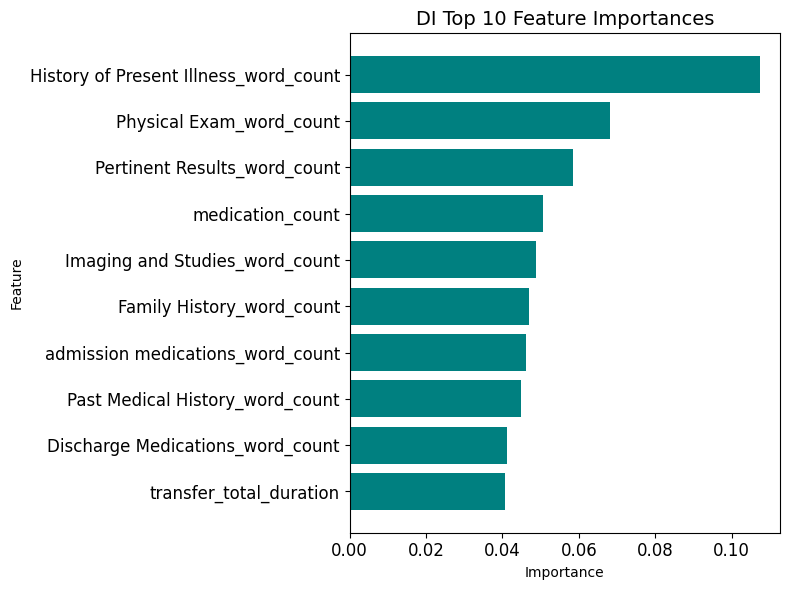

In [32]:
# Assuming clf_450 and feature_cols are defined and clf_450 has the attribute 'feature_importances_'
feature_importances = clf_280.feature_importances_

# Create a DataFrame to visualize the feature importances
importances_df = pd.DataFrame({
    'Feature': feature_cols_dis,
    'Importance': feature_importances
})

# Sort the DataFrame by importance and select the top 10
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the top 10 feature importances using ggplot style
plt.figure(figsize=(8, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='teal')
plt.xlabel('Importance', fontsize=10)  # Set the font size for x-axis label
plt.ylabel('Feature', fontsize=10)  # Set the font size for y-axis label
plt.title('DI Top 10 Feature Importances', fontsize=14)  # Set the font size for the title
plt.xticks(fontsize=12)  # Set the font size for x-axis ticks
plt.yticks(fontsize=12)  # Set the font size for y-axis ticks

plt.gca().invert_yaxis()
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.savefig('/mnt/datadisk/mimic/result/di_features.png',dpi=300)
plt.show()

### ## random forest for brief hospital course

In [33]:

# Step 1: Prepare the data
# Modify the target variable to have only two classes
# df_all['word_count_class'] = np.floor(df_all['brief_hospital_course_word_count'] / 200)
# df_all['word_count_class'] = df_all['word_count_class'].clip(upper=3)  # Ensures that all values 800+ fall into the last category
bins = [0, 450, float('inf')]
labels = ['<450', '>450']

# Apply the pd.cut function
df_all['word_count_class'] = pd.cut(df_all['brief_hospital_course_word_count'],
                                    bins=bins,
                                    labels=labels,
                                    right=False)

# Check the distribution of the new categories
print(df_all['word_count_class'].value_counts())

# Features to use for prediction remain the same




# Data for the model
X = df_all[feature_cols]
y = df_all['word_count_class']

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train the classifier
clf_450 = RandomForestClassifier(n_estimators=100, random_state=42)
clf_450.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = clf_450.predict(X_test)
print(classification_report(y_test, y_pred))

word_count_class
<450    52126
>450    16659
Name: count, dtype: int64
              precision    recall  f1-score   support

        <450       0.82      0.93      0.87     15634
        >450       0.61      0.35      0.45      5002

    accuracy                           0.79     20636
   macro avg       0.71      0.64      0.66     20636
weighted avg       0.77      0.79      0.77     20636



In [34]:

# Step 1: Prepare the data
# Modify the target variable to have only two classes
df_all['category'] = (df_all['brief_hospital_course_word_count'] > 600).astype(int)

# Features to use for prediction remain the same




# Data for the model
X = df_all[feature_cols]
y = df_all['category']

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     18243
           1       0.57      0.19      0.28      2393

    accuracy                           0.89     20636
   macro avg       0.74      0.58      0.61     20636
weighted avg       0.86      0.89      0.86     20636



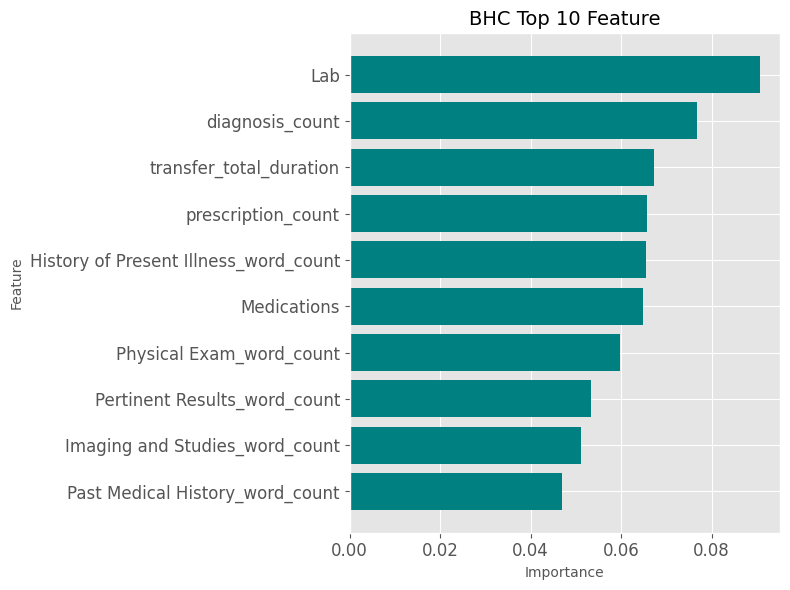

In [35]:

# Apply the ggplot style
plt.style.use('ggplot')

# Assuming clf_450 and feature_cols are defined and clf_450 has the attribute 'feature_importances_'
feature_importances = clf_450.feature_importances_

# Create a DataFrame to visualize the feature importances
importances_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances
})

# Sort the DataFrame by importance and select the top 10
importances_df = importances_df.sort_values(by='Importance', ascending=False).head(10)

# Plotting the top 10 feature importances using ggplot style
plt.figure(figsize=(8, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='teal')

plt.xlabel('Importance', fontsize=10)  # Set the font size for x-axis label
plt.ylabel('Feature', fontsize=10)  # Set the font size for y-axis label
plt.title('BHC Top 10 Feature', fontsize=14)  # Set the font size for the title
plt.xticks(fontsize=12)  # Set the font size for x-axis ticks
plt.yticks(fontsize=12) 

plt.gca().invert_yaxis()
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.savefig('/mnt/datadisk/mimic/result/bhc_features.png',dpi=300)
plt.show()